<figure>
  <IMG SRC="Logo.png"  WIDTH=150 ALIGN="right">
</figure>

## Projections of mean sea level and tides<br>
### Paper in Journal of Coastal and Hydraulic Structures
<b>Prepared by: H.G. Voortman</b>


<figure>
    <IMG SRC="https://www.python.org/static/community_logos/python-powered-w-200x80.png"  WIDTH=100 ALIGN="right">
</figure>

#### Description
- Analyses described in section 5 of the paper

#### Packages

In [66]:
# General packages
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sq
import numpy as np
#import sigfig as sf
import scipy.stats as stat
from itertools import islice, cycle

import hvec_stat.general_fit as gf
import hvec_stat.plotting as stplot
import hvec_stat.goodness_of_fit as gof
import hvec_stat.support as sup
import hvec_stat.statistical_tests as sttests
import regressionModels as mdl
import utils as prj

from constants import *

In [67]:
YR_START = 1991

In [68]:
# Settings
plt.rcParams['axes.grid'] = True
figsize = (20, 18)

In [69]:
tiny = 1e-12

In [70]:
bnd_lo = [-np.inf, -np.inf,          0,       0, -np.inf, -np.inf, -np.inf, -np.inf]
bnd_up = [ np.inf,  np.inf,     np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf]

In [71]:
# Set confidence level of interval
conf = 0.9
k = stat.norm.ppf(1 - (1 - conf) / 2)
k.round(3)

1.645

#### Connect databases and import data

##### Processed data Rijkswaterstaat

In [72]:
df = prj.read_data_rws(constit_set = 'PE')
df.dropna(how = 'all', inplace = True, axis = 'columns')

In [73]:
# selected year range modified
df = df.loc[df['year'].between(YR_START, YR_END)]

##### Data IPCC

In [74]:
ipcc = prj.read_data_ipcc()
ipcc = prj.process_ipcc(ipcc)

In [75]:
ipcc

,name,scenario,year,median,sigma,90%_band
0,Delfzijl,ssp126,2020,440.0,200.625755,330.0
1,Delfzijl,ssp245,2020,480.0,261.421438,430.0
2,Den Helder,ssp126,2020,400.0,206.705323,340.0
3,Den Helder,ssp245,2020,440.0,255.341869,420.0
4,Harlingen,ssp126,2020,400.0,206.705323,340.0
5,Harlingen,ssp245,2020,440.0,255.341869,420.0
6,Hoek Van Holland,ssp126,2020,500.0,200.625755,330.0
7,Hoek Van Holland,ssp245,2020,520.0,243.182733,400.0
8,Ijmuiden,ssp126,2020,420.0,212.784891,350.0
9,Ijmuiden,ssp245,2020,460.0,243.182733,400.0


#### Calibrate per model

In [76]:
param = pd.DataFrame(columns = [
    'name',
    'var',
    'model',
    'intercept',
    'slope',
    'sigma_slope',
    '90%_band_slope',
    'acceleration',
    'jerk',
    'A_885',
    'A_1861',
    'Rsqadj'], dtype = float)

In [77]:
vars = ['z0']

In [78]:
names = df['naam'].unique()

In [79]:
tprescr_lo = 1960
tprescr_up = 1995

In [80]:
df

,naam,level_1,z0,zmean,count,M2,S2,smean,smin,smax,...,MLWN,year,year_start,const_set,M4,O1,N2,MS4,SA,M2+S2
1265,Delfzijl,0,-0.012976,0.016685,8760.0,1.351504,0.339827,0.029656,-1.435738,2.475187,...,-1.024653,1991,1991,PE,0.175594,0.100223,0.197451,0.100847,0.091299,1.691331
1266,Delfzijl,0,0.041029,0.065377,8784.0,1.352626,0.335531,0.024750,-1.411126,2.563495,...,-0.976065,1992,1992,PE,0.178615,0.102834,0.199854,0.102835,0.056100,1.688157
1267,Delfzijl,0,0.030409,0.062823,8760.0,1.380404,0.324276,0.032325,-1.921971,2.954677,...,-1.025719,1993,1993,PE,0.190345,0.091259,0.208100,0.098940,0.055429,1.704681
1268,Delfzijl,0,0.089675,0.100833,8760.0,1.385437,0.337851,0.010731,-2.000038,3.199359,...,-0.957911,1994,1994,PE,0.190460,0.088515,0.223180,0.098935,0.062196,1.723287
1269,Delfzijl,0,0.091541,0.113196,8760.0,1.388603,0.321856,0.021863,-1.591148,2.991626,...,-0.975206,1995,1995,PE,0.185509,0.078550,0.199055,0.097395,0.049287,1.710459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7888,Vlissingen,0,0.031208,0.046079,8760.0,1.771234,0.464153,0.014713,-1.267753,2.347168,...,-1.275873,2017,2017,PE,0.125387,0.089540,0.285795,0.075327,0.095467,2.235387
7889,Vlissingen,0,-0.005708,0.000808,8760.0,1.786233,0.462828,0.005978,-1.533792,1.433112,...,-1.329113,2018,2018,PE,0.131358,0.103494,0.262831,0.076674,0.065610,2.249061
7890,Vlissingen,0,0.044007,0.050753,8760.0,1.748527,0.461571,0.007092,-1.334088,1.849021,...,-1.242949,2019,2019,PE,0.120275,0.099193,0.281222,0.071782,0.080609,2.210099
7891,Vlissingen,0,0.040856,0.058649,8784.0,1.763642,0.463379,0.018144,-1.385076,1.966732,...,-1.259407,2020,2020,PE,0.128753,0.101863,0.289820,0.068698,0.057890,2.227021


In [81]:
data = df[df['naam'] == 'Vlissingen']
vr = 'z0'

In [82]:
# Full model
tmp = pd.DataFrame()

namestore = []
varstore = []
modelstore = []
intercept = []
slope = []
acceleration = []
jerk = []
A_885 = []
A_1861 = []
t0 = []
Rsqadj = []

for vr in vars:
    for nm in names:
        """
        if nm == 'Delfzijl':
            if vr != 'z0':
                continue
        """
        data = df[df['naam'] == nm]
        res = gf.fit_with_uncert(
            mdl.fullModel,
            data['year'],
            data[vr],
            bounds = (
                bnd_lo + [tprescr_lo - data['year'].mean()],
                bnd_up + [tprescr_up - data['year'].mean()]), method = 'Bence')

        p = res['p']

        namestore.append(nm)
        varstore.append(vr)
        modelstore.append('Full')
        intercept.append(p[0])
        slope.append(p[1])
        acceleration.append(p[2])
        jerk.append(p[3])
        A_885.append(np.sqrt(p[4]**2 + p[5]**2))
        A_1861.append(np.sqrt(p[6]**2 + p[7]**2))
        t0.append(p[8] + data['year'].mean())
        Rsqadj.append(res['Rsqadj'])
        

tmp['name'] = namestore
tmp['var'] = varstore
tmp['model'] = modelstore
tmp['intercept'] = intercept
tmp['slope'] = slope
tmp['acceleration'] = acceleration
tmp['jerk'] = jerk
tmp['A_885'] = A_885
tmp['A_1861'] = A_1861
tmp['t0'] = t0
tmp['Rsqadj'] = Rsqadj

param = pd.concat([param, tmp])

s:\JCHS_sea_level\.venv\Lib\site-packages\hvec_stat\bence_method.py:65: UserWarning: Negative autocorrelation found. Correlation set to 0
  warnings.warn('Negative autocorrelation found. Correlation set to 0')


In [83]:
# Reduced model
tmp = pd.DataFrame()

namestore = []
varstore = []
modelstore = []
intercept = []
slope = []
band = []
acceleration = []
jerk = []
A_885 = []
A_1861 = []
t0 = []
Rsqadj = []

for vr in vars:
    for nm in names:
        data = df[df['naam'] == nm]
        res = gf.fit_with_uncert(
            mdl.reducedModel,
            data['year'],
            data[vr])

        p = res['p']
        sigma = res['sigma']

        namestore.append(nm)
        varstore.append(vr)
        modelstore.append('Reduced')
        intercept.append(p[0])
        slope.append(p[1])
        band.append(sigma[1] * k)
        A_885.append(np.sqrt(p[2]**2 + p[3]**2))
        A_1861.append(np.sqrt(p[4]**2 + p[5]**2))
        Rsqadj.append(res['Rsqadj'])
        

tmp['name'] = namestore
tmp['var'] = varstore
tmp['model'] = modelstore
tmp['intercept'] = intercept
tmp['slope'] = slope
tmp['90%_band_slope'] = band
tmp['sigma_slope'] = band / k
tmp['A_885'] = A_885
tmp['A_1861'] = A_1861
tmp['Rsqadj'] = Rsqadj

param = pd.concat([param, tmp])

In [84]:
# Set units (length mm and time centuries) for publication table
param['intercept'] = (1000 * param['intercept']).round()
param['slope'] = (1e5 * param['slope']).round()
param['90%_band_slope'] = (1e5 * param['90%_band_slope']).round()
param['sigma_slope'] = (1e5 * param['sigma_slope']).round()
param['acceleration'] = (1e7 * param['acceleration']).round()
param['jerk'] = (1e9 * param['jerk']).round()
param['A_885'] = (1e3 * param['A_885']).round()
param['A_1861'] = (1e3 * param['A_1861']).round()
param['Rsqadj'] = (1e2 * param['Rsqadj']).round()
#param['p-value'] = (1e2 * param['p-value']).apply(lambda x: sf.round(x, 2))
param['t0'] = param['t0'].round()

In [85]:
param.sort_values(by = ['model', 'name'], inplace = True)

In [86]:
param

,name,var,model,intercept,slope,sigma_slope,90%_band_slope,acceleration,jerk,A_885,A_1861,Rsqadj,t0
0,Delfzijl,z0,Full,92.0,315.0,NaN,NaN,0.0,3192.0,8.0,25.0,51.0,1995.0
1,Den Helder,z0,Full,-11.0,161.0,NaN,NaN,0.0,0.0,7.0,20.0,23.0,1995.0
2,Harlingen,z0,Full,39.0,381.0,NaN,NaN,0.0,0.0,7.0,16.0,42.0,1995.0
3,Hoek van Holland,z0,Full,70.0,154.0,NaN,NaN,0.0,0.0,6.0,22.0,32.0,1995.0
4,IJmuiden,z0,Full,22.0,156.0,NaN,NaN,0.0,0.0,5.0,24.0,30.0,1995.0
5,Vlissingen,z0,Full,1.0,183.0,NaN,NaN,0.0,0.0,0.0,20.0,41.0,1995.0
0,Delfzijl,z0,Reduced,94.0,341.0,69.0,113.0,NaN,NaN,8.0,25.0,57.0,NaN
1,Den Helder,z0,Reduced,-11.0,161.0,61.0,100.0,NaN,NaN,7.0,20.0,33.0,NaN
2,Harlingen,z0,Reduced,39.0,381.0,76.0,125.0,NaN,NaN,7.0,16.0,50.0,NaN
3,Hoek van Holland,z0,Reduced,70.0,154.0,54.0,89.0,NaN,NaN,6.0,22.0,40.0,NaN


In [87]:
param[(param['var'] == 'z0') & (param['model'] == 'Model 3')].drop(['var', 'intercept', 'model', 'acceleration', 'jerk', 't0'], axis = 1).to_excel(f'{RESULTS}/fitted_models_z0.xlsx', index = False)

s:\JCHS_sea_level\.venv\Lib\site-packages\hvec_stat\bence_method.py:65: UserWarning: Negative autocorrelation found. Correlation set to 0
  warnings.warn('Negative autocorrelation found. Correlation set to 0')


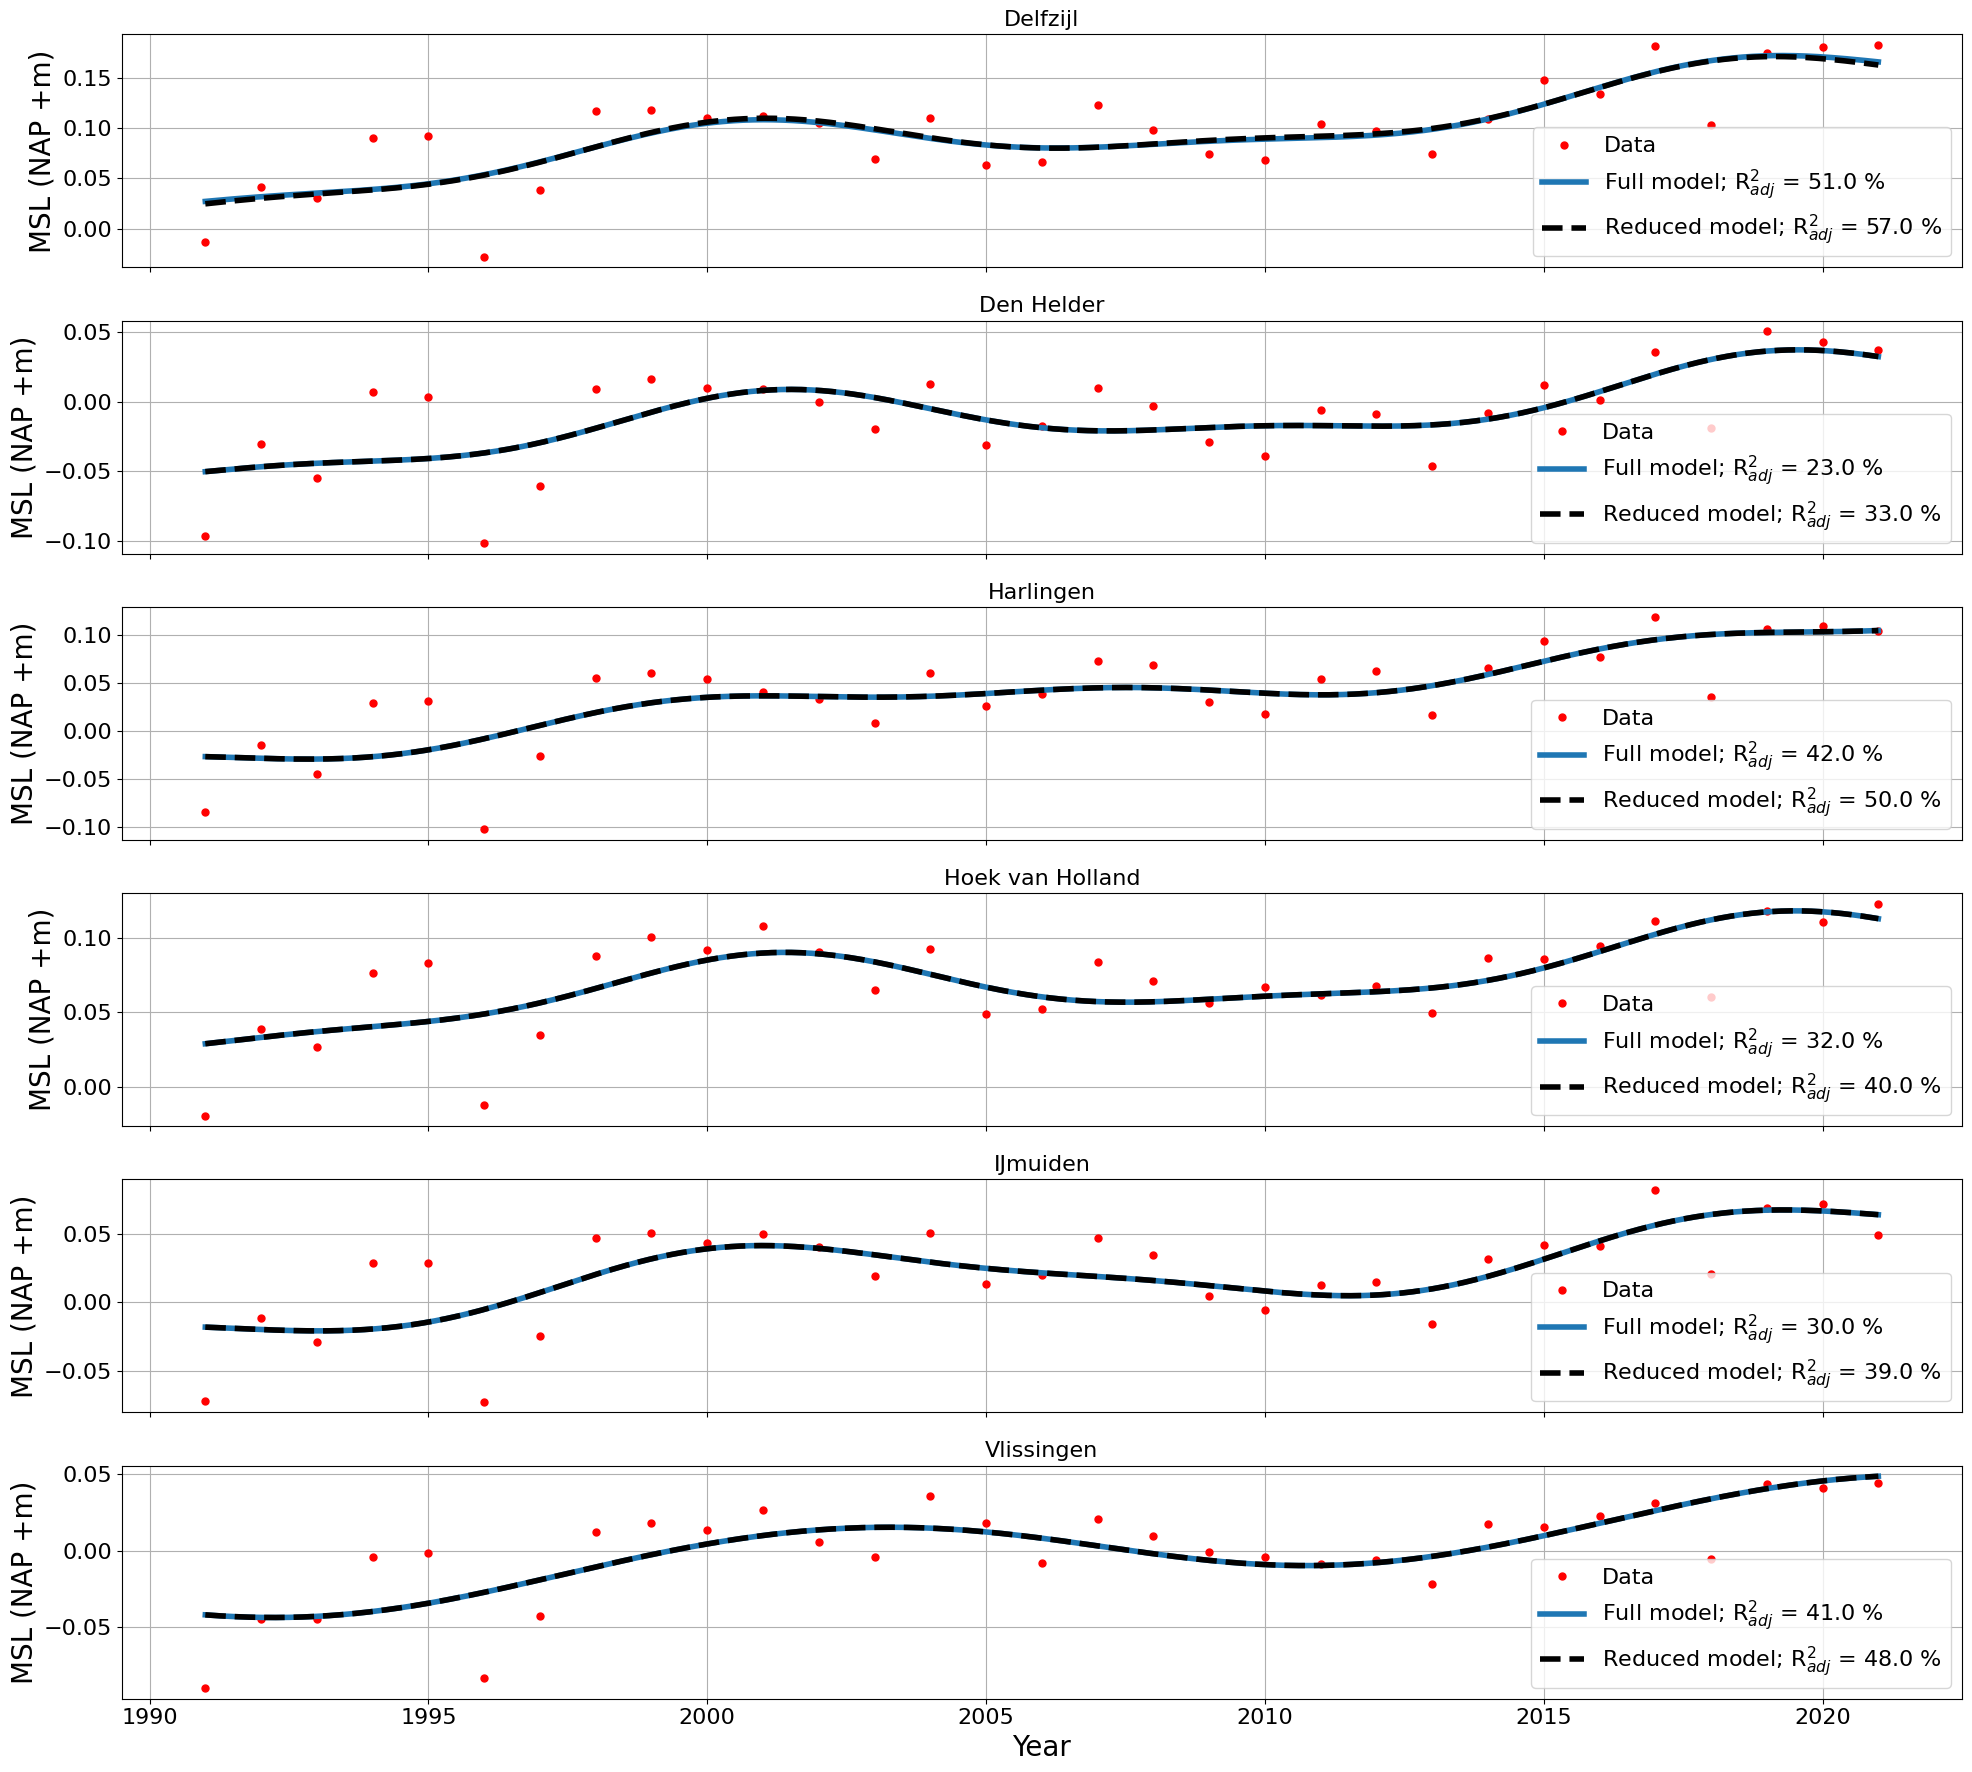

In [88]:
xgr = np.linspace(YR_START, YR_END, 1000)

fig, ax = plt.subplots(nrows = 6, ncols = 1, sharex = True, sharey = False, figsize = figsize)

for i, nm in enumerate(df['naam'].unique()):
    data = df[df['naam'] == nm]

    plt.subplot(6,1,i+1)
    
    stplot.plot_data(
        data['year'], data['z0'], 'r.', label = 'Data',
        markersize = 10)
    
    stplot.plot_model(
        mdl.fullModel, data['year'], data['z0'], xgr,
        modelname = 'Full model', method = 'Bence',
        bounds = (
            bnd_lo + [tprescr_lo - data['year'].mean()],
            bnd_up + [tprescr_up - data['year'].mean()]))
    
    stplot.plot_model(
        mdl.reducedModel, data['year'], data['z0'], xgr, fmt = 'k--',
        modelname = 'Reduced model', method = 'Bence')
    
    plt.title(nm)
    plt.ylabel('MSL (NAP +m)')

    plt.legend()

plt.xlabel('Year')
plt.tight_layout()
plt.savefig(f'{PICTURES}/z0_model6_trunc.jpg')
    

#### F-test of significance of climate signal

In [89]:
def Ftests_models(t, h, alpha):
    """
    Because of the bounds required to fit the full model, our normal procedures are not workable
    """
    ymodelRed, kRed = sup.generate_model_data(mdl.reducedModel, t, h)
    ymodelFull, kFull = sup.generate_model_data(
        mdl.fullModel, t, h,
        method = 'Bence',
        bounds = (
            bnd_lo + [tprescr_lo - t.mean()],
            bnd_up + [tprescr_up - t.mean()])
            )

    res = gof.Ftest_red(ydata = h, ymodel_full = ymodelFull, ymodel_red = ymodelRed, kfull = kFull, kred = kRed, alpha = alpha)
    return pd.DataFrame(res, index = [0])


In [90]:
Fresult = df.groupby('naam').apply(
    lambda x: Ftests_models(x['year'], x['z0'], alpha = (0.05 / 6))
)

s:\JCHS_sea_level\.venv\Lib\site-packages\hvec_stat\bence_method.py:65: UserWarning: Negative autocorrelation found. Correlation set to 0
  warnings.warn('Negative autocorrelation found. Correlation set to 0')


In [91]:
Fresult.reset_index(inplace = True)
Fresult.drop(columns = 'level_1', inplace = True)

In [92]:
Fresult

,naam,F,p,alpha,Falpha,Reject_H0
0,Delfzijl,1.022509e-02,0.998536,0.008333,5.094218,False
1,Den Helder,-1.971354e-06,1.000000,0.008333,5.094218,False
2,Harlingen,-1.222949e-06,1.000000,0.008333,5.094218,False
3,Hoek van Holland,-2.601319e-06,1.000000,0.008333,5.094218,False
4,IJmuiden,-6.270837e-07,1.000000,0.008333,5.094218,False
5,Vlissingen,-3.874087e-07,1.000000,0.008333,5.094218,False


#### Comparison to IPCC

In [93]:
ipcc = cp.copy(ipcc[['name', 'scenario', 'year', 'median']])
ipcc

,name,scenario,year,median
0,Delfzijl,ssp126,2020,440.0
1,Delfzijl,ssp245,2020,480.0
2,Den Helder,ssp126,2020,400.0
3,Den Helder,ssp245,2020,440.0
4,Harlingen,ssp126,2020,400.0
5,Harlingen,ssp245,2020,440.0
6,Hoek Van Holland,ssp126,2020,500.0
7,Hoek Van Holland,ssp245,2020,520.0
8,Ijmuiden,ssp126,2020,420.0
9,Ijmuiden,ssp245,2020,460.0


In [94]:
ipcc = ipcc.pivot(index = 'name', columns = 'scenario', values = 'median')
#ipcc.reset_index(inplace = True)

In [95]:
param = param.loc[param['model'] == 'Reduced', ['name', 'slope']]
param.rename(columns = {
    'slope': 'empirical',
}, inplace = True)
param['name'] = param['name'].str.title()
param.set_index(keys = 'name', inplace = True)
param

,empirical
name,
Delfzijl,341.0
Den Helder,161.0
Harlingen,381.0
Hoek Van Holland,154.0
Ijmuiden,156.0
Vlissingen,183.0


In [96]:
all = pd.concat([param, ipcc], axis = 1)
all.rename(columns = {
      'empirical': 'Rate in 2020 from observations 1991 - 2022'
    , 'ssp126': 'Rate in 2020 from ssp1-2.6'
    , 'ssp245': 'Rate in 2020 from ssp2-4.5'
}, inplace = True)
all

,Rate in 2020 from observations 1991 - 2022,Rate in 2020 from ssp1-2.6,Rate in 2020 from ssp2-4.5
name,,,
Delfzijl,341.0,440.0,480.0
Den Helder,161.0,400.0,440.0
Harlingen,381.0,400.0,440.0
Hoek Van Holland,154.0,500.0,520.0
Ijmuiden,156.0,420.0,460.0
Vlissingen,183.0,420.0,440.0


In [97]:
my_colors = list(islice(cycle(['green', 'orange', 'y', 'y', 'k']), None, len(all)))

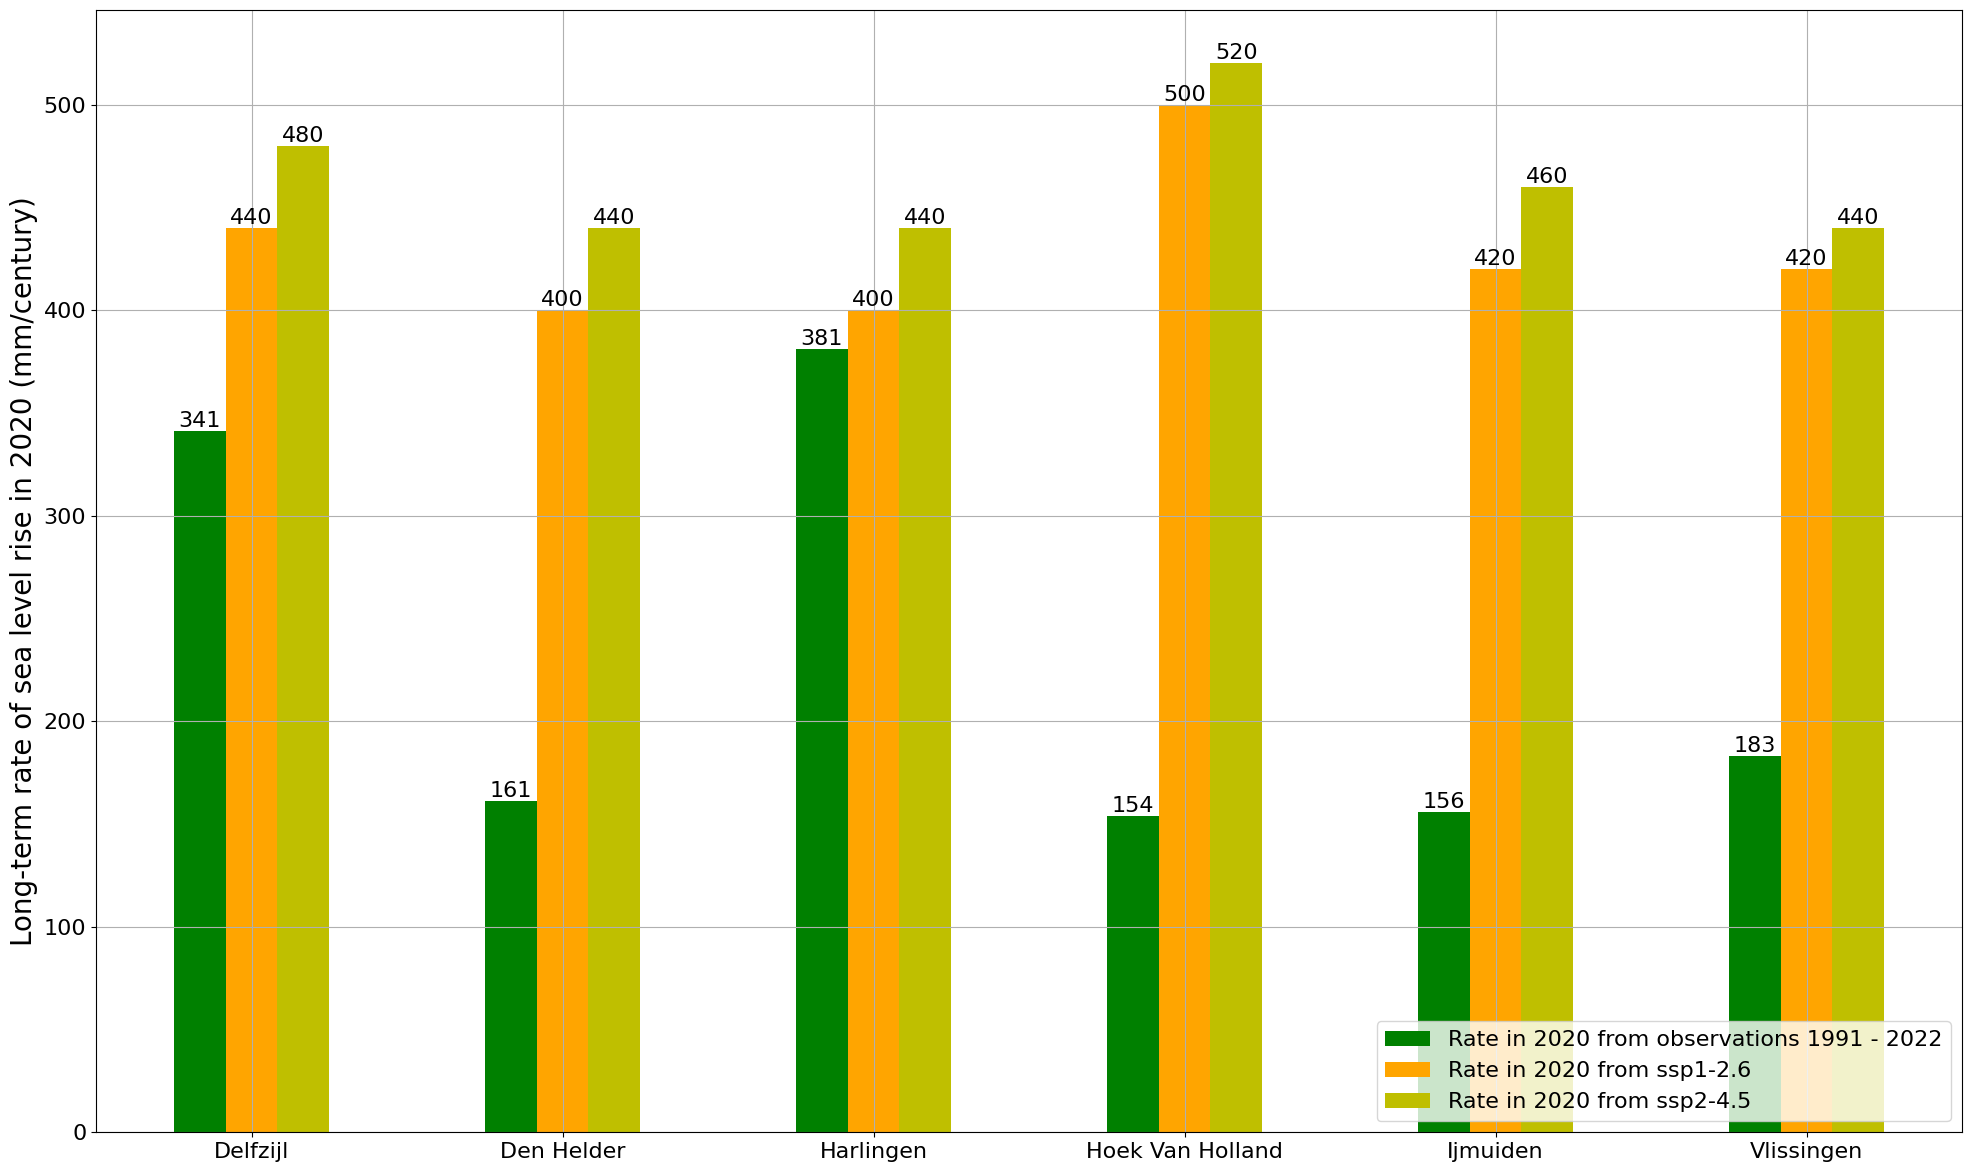

In [98]:
ax = all.plot.bar(figsize = (20, 12), color = my_colors, rot = 0)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.set_xlabel(None)
ax.set_ylabel('Long-term rate of sea level rise in 2020 (mm/century)')
ax.legend(loc = 'lower right')
plt.tight_layout()
plt.savefig(f'{PICTURES}/rates_compared.jpg');

#### End script
Prepared by HVEC lab, 2022